In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
from acnportal.acnsim import analysis
# from modified_evse import *
from acnportal.acnsim.models.evse import get_evse_by_type

#### EV Charging Network

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=30):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(2)]
    BC_ids = ['BC-{0}'.format(i) for i in range(3)]
    CA_ids = ['CA-{0}'.format(i) for i in range(3)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

#### Simulation Parameters

In [4]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts

# Default maximum charging rate for each EV battery.
DEFAULT_BATTERY_POWER = 11 # kW

#### Generate synthetic events for simulation

In [5]:
# Generate synthetic events based on JPL data provided by ACN-Sim.
class CustomUnpicklerJPLdata(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "sklearn.mixture.gaussian_mixture":
            return sklearn.mixture.GaussianMixture
        if name == "GaussianMixture":
            return sklearn.mixture.GaussianMixture
        return super().find_class(module, name)
    
def get_synth_events(sessions_per_day):
    gmm = CustomUnpicklerJPLdata(open('./data/jpl_weekday_40.pkl', "rb")).load()


    # Generate a list of the number of sessions to draw for each day.
    # This generates 30 days of charging demands.
    # num_evs = [0]*2 + [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2 + \
    #           [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2

    # Generate sessions for 1 day (weekdays only)
    num_evs = [0]*2 + [sessions_per_day]*1

    # Note that because we are drawing from a distribution, some sessions will be
    # invalid, we ignore these sessions and remove the corresponding plugin events.
    gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=0.08334)

    synth_events = gen.generate_events(num_evs, PERIOD, VOLTAGE, DEFAULT_BATTERY_POWER)
    return synth_events

In [6]:
# 20 EV sessions per weekday
# events_20_ev = get_synth_events(20)

# Reading the stored data from another variable's notebook
%store -r events_20_ev
# print(events_20_ev)

In [7]:
# Checking session details
session_copy = deepcopy(events_20_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

643 session_16 763 5.380930692889361 Plugin
645 session_5 719 8.418957775054917 Plugin
647 session_2 781 12.511400288009494 Plugin
664 session_7 700 4.620387752405969 Plugin
663 session_19 769 14.74235888815547 Plugin
648 session_0 771 8.884954144697257 Plugin
662 session_6 714 13.90421873268636 Plugin
666 session_1 790 13.224891830666355 Plugin
675 session_17 729 22.25335523083723 Plugin
673 session_10 784 5.427240899781867 Plugin
691 session_4 723 21.77831836796635 Plugin
668 session_11 794 6.155935368103842 Plugin
662 session_12 774 22.03247681841774 Plugin
764 session_13 783 2.37994271113687 Plugin
679 session_14 781 8.164418565255309 Plugin
676 session_3 805 11.709361845744985 Plugin
672 session_15 772 9.162386699786166 Plugin
754 session_8 778 11.62497864207491 Plugin
698 session_18 739 7.670480385761389 Plugin
706 session_9 753 1.4826989016557042 Plugin


#### Algorithms 

In [8]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.total_energy, 1000),
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-5),
                modified_adacharge.ObjectiveComponent(modified_adacharge.equal_share, 1e-11)
               ]

sch['MPC_withoutAQ'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=200, max_recompute=1)
# Getting an error using following format. Is it because of network type?
# sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", peak_limit=200, max_recompute=1)

# cost_min_obj_off = [
#                     modified_adacharge.ObjectiveComponent(modified_adacharge.total_energy, 1000),
#                     modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost),
#                    ]
# sch['MPC_Offline'] = modified_adacharge.AdaptiveChargingAlgorithmOffline(cost_min_obj_off, solver="MOSEK")


#### Run Simulations

In [9]:
sims = dict()

In [10]:
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2024, 2, 28))
    end = timezone.localize(datetime(2024, 2, 28))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events_20_ev)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = acnsim.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "MPC_Offline":
        alg.register_events(experiment_events)
        alg.solve()
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [11]:
warnings.simplefilter("ignore")

capacities = list(range(40, 86, 5))
alg_names = ["Unctrl", "LLF", "RR", "MPC_withoutAQ"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        if config not in sims:
            sims[config] = run_experiment(*config)

('Unctrl', 40)
32.1285140562249
57.971014492753625
Running...
Run time: 0.5364851951599121
('LLF', 40)
32.1285140562249
57.971014492753625
Running...
Run time: 1.2604737281799316
('RR', 40)
32.1285140562249
57.971014492753625
Running...
Run time: 1.8842570781707764
('MPC_withoutAQ', 40)
32.1285140562249
57.971014492753625
Running...
Run time: 15.522585153579712
('Unctrl', 45)
36.144578313253014
65.21739130434783
Running...
Run time: 0.4657104015350342
('LLF', 45)
36.144578313253014
65.21739130434783
Running...
Run time: 1.1081459522247314
('RR', 45)
36.144578313253014
65.21739130434783
Running...
Run time: 1.669121503829956
('MPC_withoutAQ', 45)
36.144578313253014
65.21739130434783
Running...
Run time: 14.3341383934021
('Unctrl', 50)
40.16064257028113
72.46376811594203
Running...
Run time: 0.422405481338501
('LLF', 50)
40.16064257028113
72.46376811594203
Running...
Run time: 1.0657179355621338
('RR', 50)
40.16064257028113
72.46376811594203
Running...
Run time: 1.6651151180267334
('MPC_

In [12]:
result_dir = "results/sims/paper_results_withoutAQ"
if not os.path.exists("results/sims/paper_results_withoutAQ"):
    os.makedirs("results/sims/paper_results_withoutAQ")
    
for config, sim in sims.items():
    name = "results/sims/paper_results_withoutAQ/{0}-{1}.json.gz".format(*config)
    if not os.path.exists(name):
        data = sim.to_json()
        with gzip.GzipFile(name, 'w') as fout:
            fout.write(json.dumps(data).encode('utf-8'))

#### Results Analysis

- Proportion of total energy requested which is delivered
- Maximum instantaneous power draw over the capacity of the system
- Average current imbalance

In [13]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Demand met": analysis.proportion_of_demands_met(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "energy_cost": analysis.energy_cost(sim),
        "total_energy_delivered": analysis.total_energy_delivered(sim),
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [14]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [15]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Peak (kW),Current Unbalance
0,three_phase,Unctrl,40,100.000,100.0,197.127,14.980,211.530,78.851,0.382
1,three_phase,LLF,40,71.640,65.0,90.275,11.119,151.539,36.110,0.416
2,three_phase,RR,40,70.498,65.0,90.262,10.775,149.125,36.105,0.408
3,three_phase,MPC_withoutAQ,40,71.996,65.0,93.900,11.059,152.292,37.560,0.400
4,three_phase,Unctrl,45,100.000,100.0,175.224,14.980,211.530,78.851,0.331
5,three_phase,LLF,45,71.681,65.0,83.467,11.112,151.627,37.560,0.449
6,three_phase,RR,45,71.160,65.0,91.300,10.919,150.525,41.085,0.432
7,three_phase,MPC_withoutAQ,45,71.546,70.0,100.522,10.914,151.341,45.235,0.367
8,three_phase,Unctrl,50,100.000,100.0,157.701,14.980,211.530,78.851,0.349
9,three_phase,LLF,50,71.623,60.0,73.050,11.047,151.505,36.525,0.460


In [16]:
metrics.groupby(["Algorithm", "Network Type"])["Energy Delivered (%)"].describe()

,,count,mean,std,min,25%,50%,75%,max
Algorithm,Network Type,,,,,,,,
LLF,three_phase,10.0,71.6669,0.021310,71.623,71.66200,71.674,71.67400,71.697
MPC_withoutAQ,three_phase,10.0,72.1257,0.257610,71.546,72.06350,72.267,72.27475,72.275
RR,three_phase,10.0,71.5025,0.387825,70.498,71.65525,71.674,71.67400,71.674
Unctrl,three_phase,10.0,100.0000,0.000000,100.000,100.00000,100.000,100.00000,100.000


In [17]:
metrics.groupby(["Algorithm", "Network Type"])["Peak (kW)"].describe()

,,count,mean,std,min,25%,50%,75%,max
Algorithm,Network Type,,,,,,,,
LLF,three_phase,10.0,41.7985,3.514721,36.110,39.11750,44.0000,44.0000,44.000
MPC_withoutAQ,three_phase,10.0,51.8175,6.716958,37.560,47.93375,54.5775,57.2775,57.485
RR,three_phase,10.0,42.9190,2.563475,36.105,44.00000,44.0000,44.0000,44.000
Unctrl,three_phase,10.0,78.8510,0.000000,78.851,78.85100,78.8510,78.8510,78.851


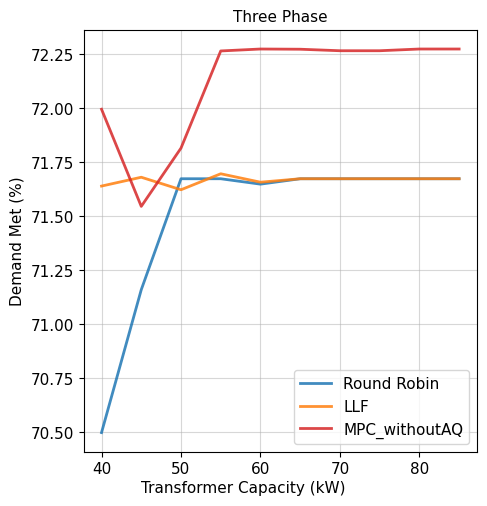

In [18]:
from matplotlib import cm
 
plt.style.use('default')

energy_delivered= metrics.pivot_table("Energy Delivered (%)", "capacity", ["Network Type", "Algorithm"])
energy_delivered.rename(columns={'RR': 'Round Robin'}, inplace=True)

column_order = ['Round Robin', 'LLF', 'MPC_withoutAQ']
cap_range = (40, 86)

cmap = cm.get_cmap('tab20')
li = 0
# label2color = {'FCFS': cmap(0+li), 'EDF': cmap(2+li), 'LLF': cmap(4+li), 'Round Robin': cmap(6+li), 
#                'Offline Optimal': cmap(8), 'MPC': cmap(9)}

label2color = {'Round Robin': cmap(0+li), 'LLF': cmap(2+li), 'MPC_withoutAQ': cmap(6)}

style = {
    "color": [label2color[col] for col in column_order],
    "style": ["-"]*5 + ["*"],
    "linewidth": 2,
    "alpha": .85,
    # "marker": ["."]*5 + [None],
    #"fillstyle": "none",
    "legend": False,
}

plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(nrows=1, figsize=(7, 7), sharey=True)
energy_delivered["three_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(ax=ax, **style)
ax.legend(loc="best")

ax.set_title("Three Phase", fontsize=11)

fig.text(0.5, 0, "Transformer Capacity (kW)", ha='center')

# ax.set_ylim(80,100)

ax.set_xlabel("")

ax.set_ylabel("Demand Met (%)")

ax.grid(alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.tight_layout()

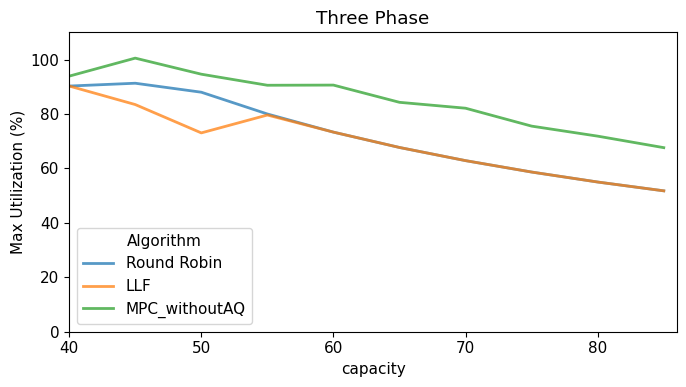

In [19]:
utilization = metrics.pivot_table("Max Utilization (%)", "capacity", ["Network Type", "Algorithm"])
utilization.rename(columns={'RR': 'Round Robin'}, inplace=True)
column_order = ['Round Robin', 'LLF', 'MPC_withoutAQ']
cap_range = (40, 86)

fig, axes = plt.subplots(1, figsize=(7, 4), sharey=True)
utilization["three_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(linewidth=2, alpha=0.75, ax=axes)
axes.set_xlim(40, 86)
axes.set_ylim(0, 110)

axes.set_ylabel('Max Utilization (%)')
axes.set_title("Three Phase")

plt.tight_layout()

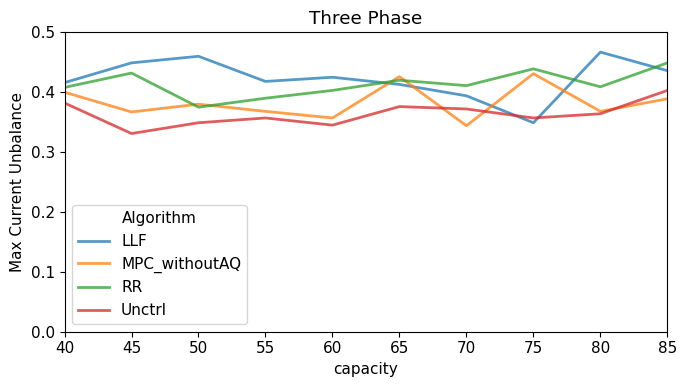

In [20]:
current_unbalance = metrics.pivot_table("Current Unbalance", "capacity", ["Network Type", "Algorithm"])
fig, ax = plt.subplots(1, figsize=(7, 4), sharey=True)
current_unbalance["three_phase"].plot(linewidth=2, alpha=0.75, ax=ax)
ax.set_xlim(40, 85)
ax.set_ylim(0,0.5)
ax.set_ylabel("Max Current Unbalance")
ax.set_title("Three Phase")
plt.tight_layout()

##### Line Currents

In [ ]:
# currents = analysis.constraint_currents(sims[("MPC", 50)])
# fig, axes = plt.subplots(1, figsize=(7, 4), sharey=True)
# axes.plot(currents["Secondary B"], label="Secondary B")

In [21]:
def plot_line_currents(sims, names, start, length):
  fig, axes = plt.subplots(2, len(sims), sharey='row', sharex=True, figsize=(7, 7))
  axes[0,0].set_xlim(start, start+length)
  fig.subplots_adjust(wspace=0.07, hspace=0.07)
  for i, sim in enumerate(sims):
    cc = analysis.constraint_currents(sim)
    for line in 'ABC': 
      axes[0, i].plot(cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), linewidth=2)
      axes[1, i].plot(cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), linewidth=2)

    axes[1, i].axhline(40, color='gray', linestyle='--')
    axes[0, i].axhline(20, color='gray', linestyle='--')
    axes[0, i].set_title(names[i])
    
  axes[0,-1].legend()
  axes[1,-1].legend()
  plt.show()
  return fig

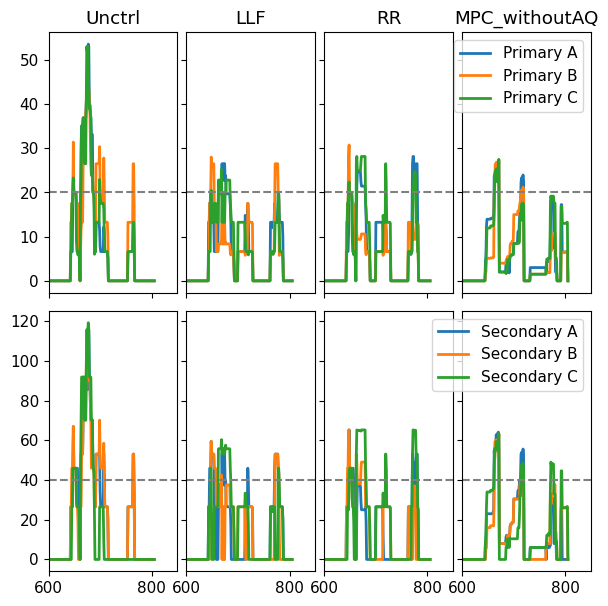

In [22]:
alg_order = ["Unctrl", "LLF", "RR", "MPC_withoutAQ"]
# print([sims[alg, 50] for alg in alg_order])
fig = plot_line_currents([sims[alg, 45] for alg in alg_order], alg_order, 600, 250)

#### EV Charging Profile

In [23]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    ax.step(x, sim.charging_rates[evse_index][ev.arrival:ev.departure],
            label=label, linewidth=2)
    if label_auto_place:
        ax.legend()
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

def plot_profiles(sims, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(4, 1, sharey=True, sharex=True, figsize=(7, 6))

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 35)
    axes[0].set_yticks([0, 15, 35])
    
    plt.subplots_adjust(hspace=.2)
    fig.text(0.035, 0.55, 'Charging Current (A)', va='center', rotation='vertical')
    print(ev.session_id)
    for i, alg_name in enumerate(["Unctrl", "RR", "LLF", "MPC_withoutAQ"]):
        label = alg_name if alg_name != "Offline" else "Offline Optimal"
        plot_ev_charging(sims[alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    return fig

session_16


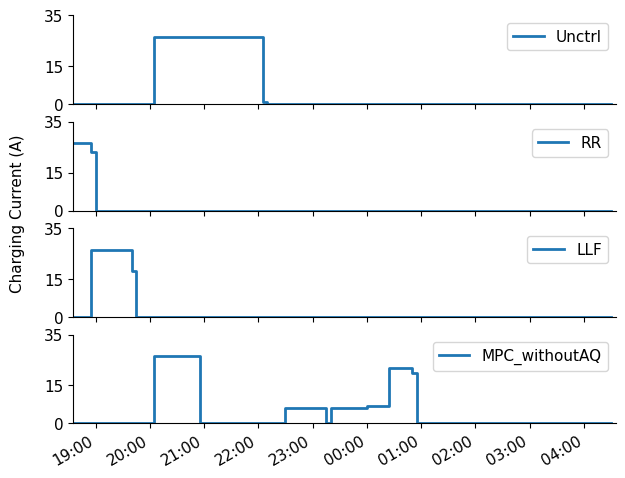

In [53]:
ev = random.choice(list(sims["RR", cap].ev_history.values()))
cap = 60
plot_profiles(sims, cap, ev, label_auto_place=True)
plt.show()

In [54]:
# cmap = sns.diverging_palette(220, 20, n=10)
# colors = [cmap[1], cmap[2], cmap[3], cmap[7], cmap[8]]
# opt_color = cmap[9]
# bar_width = 0.75

# order = ['Unctrl', 'RR', 'LLF', 'MPC']
# fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
pt = metrics.pivot(index='capacity', columns='Algorithm')
selected_matrix = pt[['Energy Delivered (%)', 'energy_cost']].loc[capacities]
selected_matrix

# Energy Cost
# pt['energy_cost'][order].loc[capacity].plot.bar(ax=ax[1], linewidth=1, edgecolor='w', color=colors, width=bar_width, legend=False)
# # ax[1].fill_between([-1, 5], 0, pt['energy_cost']['Optimal']['I'], facecolor='grey', alpha=0.25)
# ax[1].set_ylim(2000, 2550)
# ax[1].set_ylabel('Energy\nCost ($)')

Energy Delivered (%)                              energy_cost  \
Algorithm                  LLF MPC_withoutAQ      RR Unctrl         LLF   
capacity                                                                  
40                      71.640        71.996  70.498  100.0      11.119   
45                      71.681        71.546  71.160  100.0      11.112   
50                      71.623        71.816  71.674  100.0      11.047   
55                      71.697        72.266  71.674  100.0      10.938   
60                      71.658        72.275  71.649  100.0      10.929   
65                      71.674        72.274  71.674  100.0      10.932   
70                      71.674        72.267  71.674  100.0      10.932   
75                      71.674        72.267  71.674  100.0      10.932   
80                      71.674        72.275  71.674  100.0      10.932   
85                      71.674        72.275  71.674  100.0      10.932   

                                        
Algorithm MPC_withoutAQ      RR Unctrl  
capacity                                
40               11.059  10.775  14.98  
45               10.914  10.919  14.98  
50               10.929  10.932  14.98  
55               10.963  10.932  14.98  
60               10.933  10.929  14.98  
65               10.917  10.932  14.98  
70               10.887  10.932  14.98  
75               10.893  10.932  14.98  
80               10.889  10.932  14.98  
85               10.889  10.932  14.98